In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

plt.style.use("ggplot")

In [2]:
# Original and output data folders + images folder
original = Path("../original/")
output = Path("../output/")
images = Path("../images/")

In [3]:
# Import saved data
MilkMeasurements = pd.read_csv(output / "MilkMeasurementsPlusGroupedTarget.csv")

# Data recording period

In [4]:
# Cast date to correct type
MilkMeasurements["SampleDate"] = MilkMeasurements["SampleDate"].astype("datetime64[D]")

# Convert farm name to string to avoid scaling in figure axis
MilkMeasurements["ManagementAreaId"] = MilkMeasurements["ManagementAreaId"].astype(str)

In [5]:
# Get start and end dates of recording milk measurements for each farm
MilkMeasurementsMinMaxDates = (
    MilkMeasurements.groupby("ManagementAreaId")
    .agg(
        SampleDateMin=("SampleDate", "min"),
        SampleDateMax=("SampleDate", "max"),
        SamplesCount=("SampleDate", "size"),
    )
    .reset_index()
)

# Compute date difference in days
MilkMeasurementsMinMaxDates["DateDiff"] = (
    MilkMeasurementsMinMaxDates["SampleDateMax"]
    - MilkMeasurementsMinMaxDates["SampleDateMin"]
)

# Sort values
MilkMeasurementsMinMaxDates = MilkMeasurementsMinMaxDates.sort_values(
    "SamplesCount", ascending=False
)

# Overview
MilkMeasurementsMinMaxDates.head()

,ManagementAreaId,SampleDateMin,SampleDateMax,SamplesCount,DateDiff
18,750,2022-03-25,2023-11-10,283,595 days
1,1867,2022-06-13,2023-11-20,281,525 days
0,1524,2022-03-25,2023-11-20,241,605 days
12,1908,2022-12-01,2023-11-08,185,342 days
10,1906,2022-12-01,2023-11-08,184,342 days


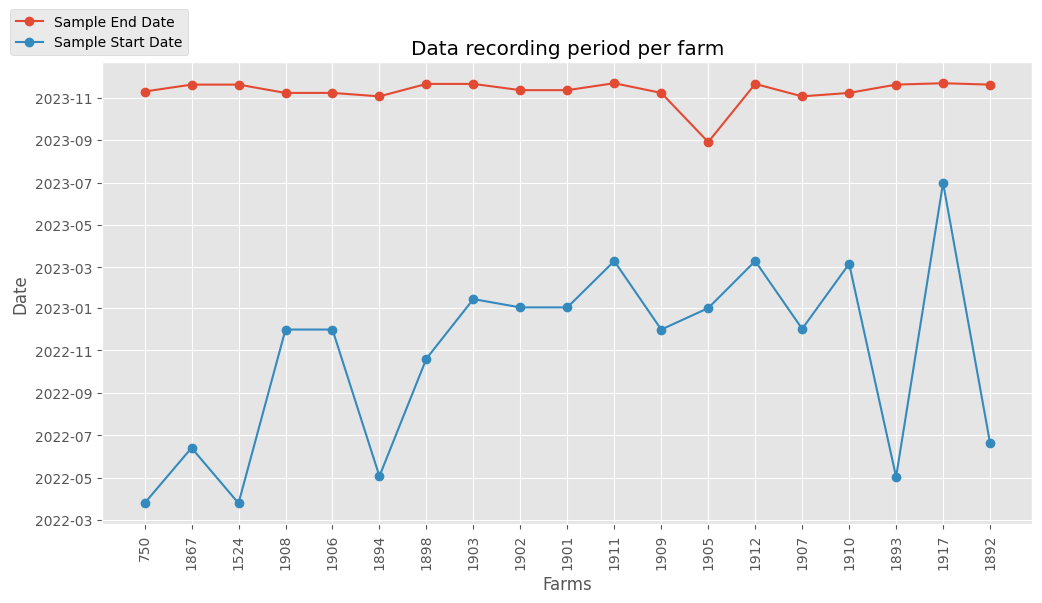

In [6]:
# Plot data recording period by farm
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    MilkMeasurementsMinMaxDates["ManagementAreaId"],
    MilkMeasurementsMinMaxDates["SampleDateMax"],
    label="Sample End Date",
    marker="o",
)
ax.plot(
    MilkMeasurementsMinMaxDates["ManagementAreaId"],
    MilkMeasurementsMinMaxDates["SampleDateMin"],
    label="Sample Start Date",
    marker="o",
)
ax.set_xlabel("Farms")
ax.set_ylabel("Date")
title = "Data recording period per farm"
ax.set_title(title)
ax.legend()
ax.legend(bbox_to_anchor=(0.1, 1.13))
plt.xticks(rotation=90)
plt.savefig(images / f"{title}.png")
plt.show()

# Number of samples per farm

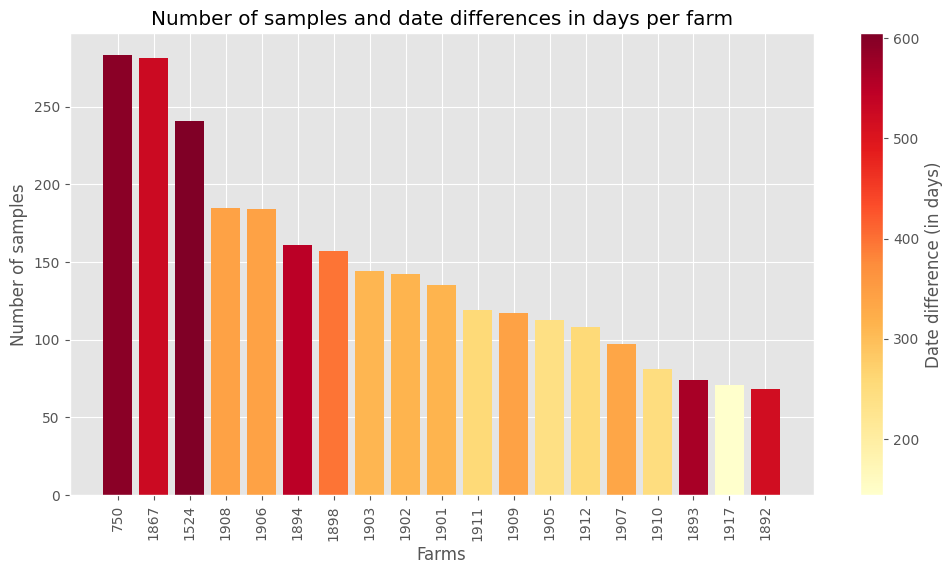

In [7]:
# Normalize DateDiff to create a gradient color bar
norm = plt.Normalize(
    MilkMeasurementsMinMaxDates["DateDiff"].dt.days.min(),
    MilkMeasurementsMinMaxDates["DateDiff"].dt.days.max(),
)
colors = cm.YlOrRd(norm(MilkMeasurementsMinMaxDates["DateDiff"].dt.days))

# Plot the bars
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(
    MilkMeasurementsMinMaxDates["ManagementAreaId"],
    MilkMeasurementsMinMaxDates["SamplesCount"],
    color=colors,
)
ax.set_xlabel("Farms")
ax.set_ylabel("Number of samples")
title = "Number of samples and date differences in days per farm"
ax.set_title(title)
plt.xticks(rotation=90)

# Add the gradient color bar
sm = plt.cm.ScalarMappable(cmap=cm.YlOrRd, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Date difference (in days)")

# Save and display the plot
plt.savefig(images / f"{title}.png")
plt.show()

In [8]:
animal_cols = ["Species", "Breed"]
AnimalCountPerFarm = (
    MilkMeasurements[["ManagementAreaId"] + animal_cols]
    .drop_duplicates()
    .groupby(animal_cols)
    .size()
    .reset_index()
    .rename(columns={0: "NumberOfFarms"})
)
AnimalCountPerFarm.to_csv(output / "AnimalCountPerFarm.csv", index=False)
AnimalCountPerFarm

,Species,Breed,NumberOfFarms
0,Cabra,Florida,5
1,Cabra,Malagueña,6
2,Cabra,Murciano-granadina,3
3,Cabra,Payoya,3
4,Oveja,Assaf,1
5,Vaca,Frisona,1


# Measurement distributions per farm, species and breed

In [9]:
# Sort data by animal breed and species
MilkMeasurements.sort_values(["Species", "Breed"], inplace=True)

In [10]:
# The measurement ranges
MeasurementRange = pd.read_excel(original / "MeasurementRange.xlsx")

# Convert farm name to string to avoid scaling in figure axis
MeasurementRange["ManagementAreaId"] = MeasurementRange["ManagementAreaId"].astype(str)

In [11]:
# Milk characteristics labels in Spanish
MeasurementType = pd.read_excel(original / "MeasurementType.xlsx")

# Milk characteristics in English to match MilkMeasurements column names
MeasurementType["Measurement"] = [
    "Quantity",
    "EQ",
    "SomaticCellCount",
    "Fat",
    "Protein",
    "Bacteria",
    "Urea",
    "ES",
    "Casein",
    "Lactose",
    "FreezingPoint",
    "NumberOfAnimals",
]

# Drop quantity and number of animals because their values are unavailable, casein and lactose because they're unused in the recommandation algorithm
MeasurementType = MeasurementType[
    ~MeasurementType["Measurement"].isin(
        ["Quantity", "NumberOfAnimals", "Casein", "Lactose"]
    )
]

# Rename Id to MeasurementTypeId to match other tables' columns
MeasurementType.rename(columns={"Id": "MeasurementTypeId"}, inplace=True)

# Drop Spanish measurement names
MeasurementType.drop(columns="Name", inplace=True)

# Overview
MeasurementType

,MeasurementTypeId,Measurement
1,2,EQ
2,3,SomaticCellCount
3,4,Fat
4,5,Protein
5,6,Bacteria
6,7,Urea
7,8,ES
10,11,FreezingPoint


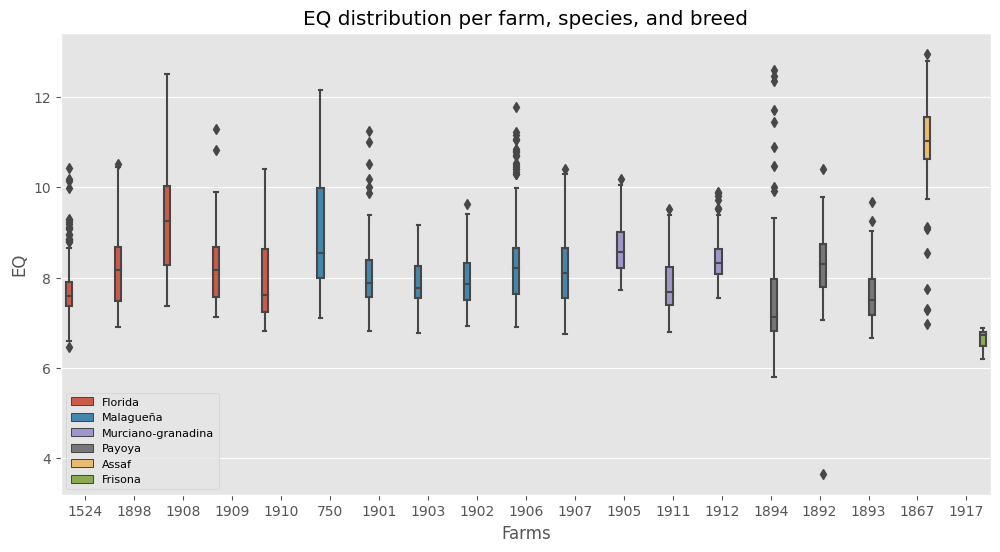

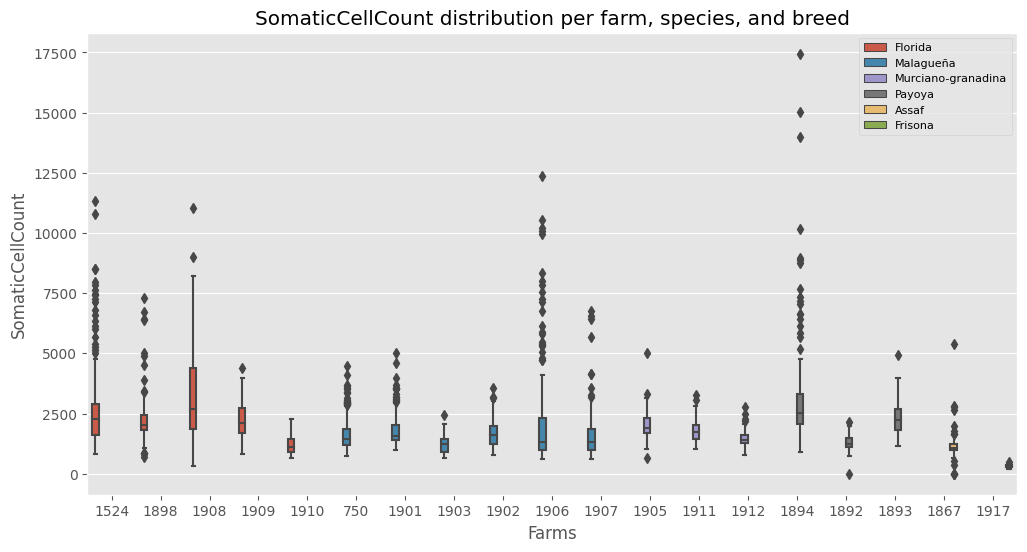

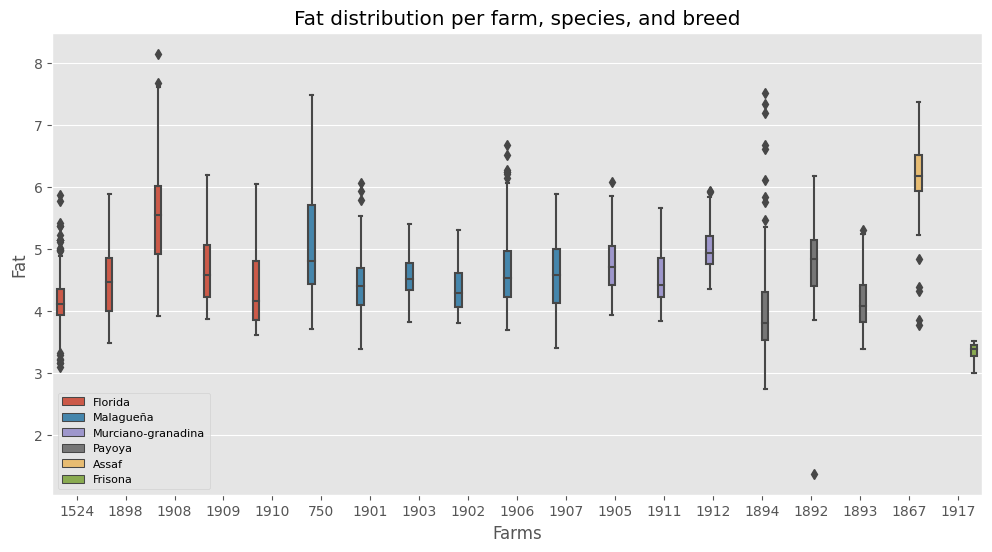

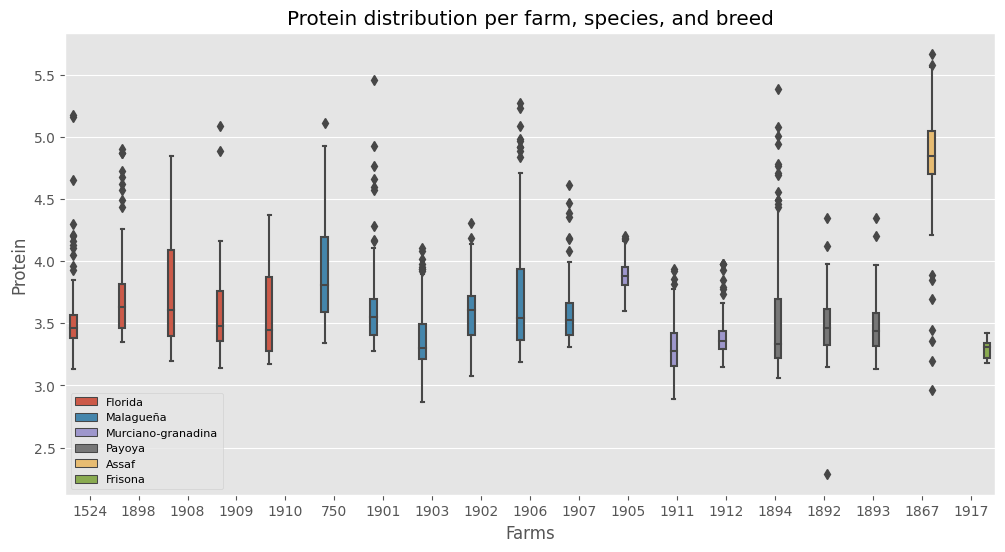

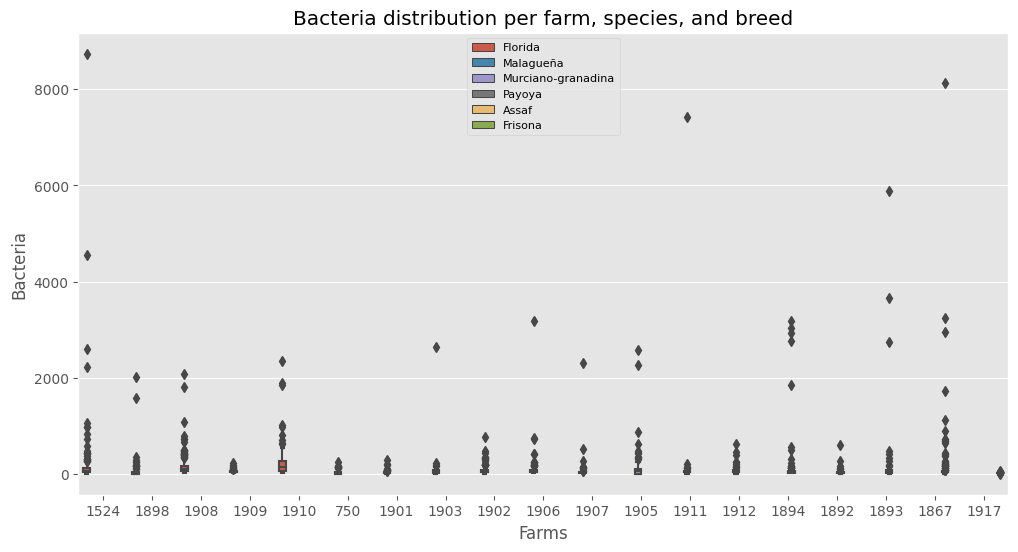

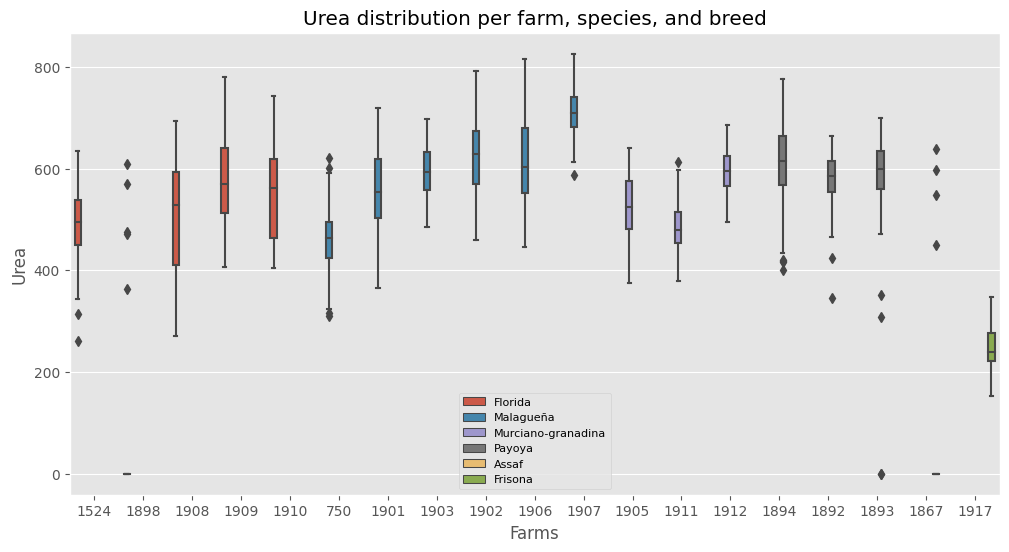

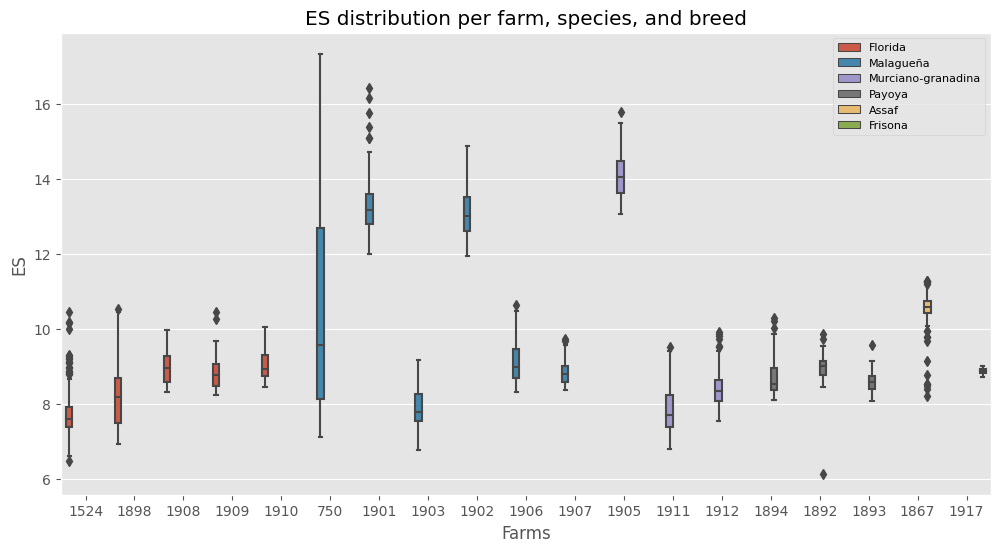

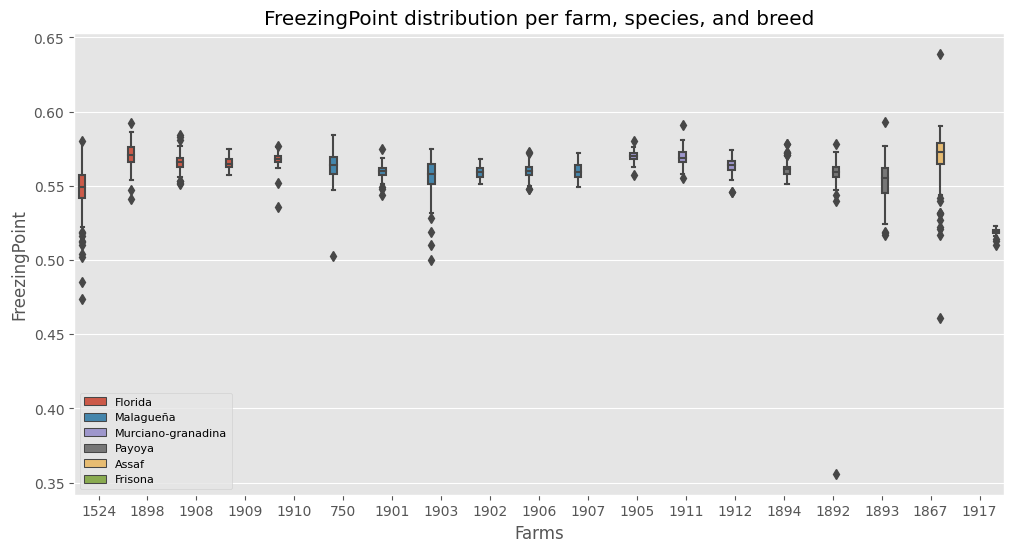

In [12]:
# Plot measurements' distributions per farm, and animal species and breed
images_subfolder = Path("1 - Measurement distributions per farm, species, and breed")
for _, (MeasurementTypeId, Measurement) in MeasurementType.iterrows():
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="ManagementAreaId", y=Measurement, hue="Breed", data=MilkMeasurements)
    ax.set_xlabel("Farms")
    title = f"{Measurement} distribution per farm, species, and breed"
    ax.set_title(title)
    ax.legend(fontsize=8)
    plt.savefig(images / images_subfolder / f"{title}.png")
    plt.show()

# Measurement trigger values per farm

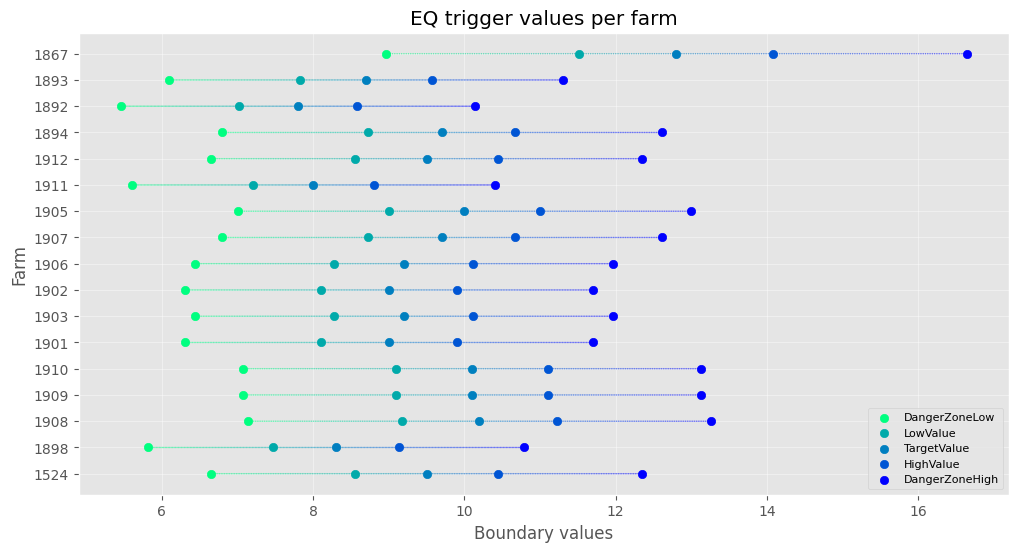

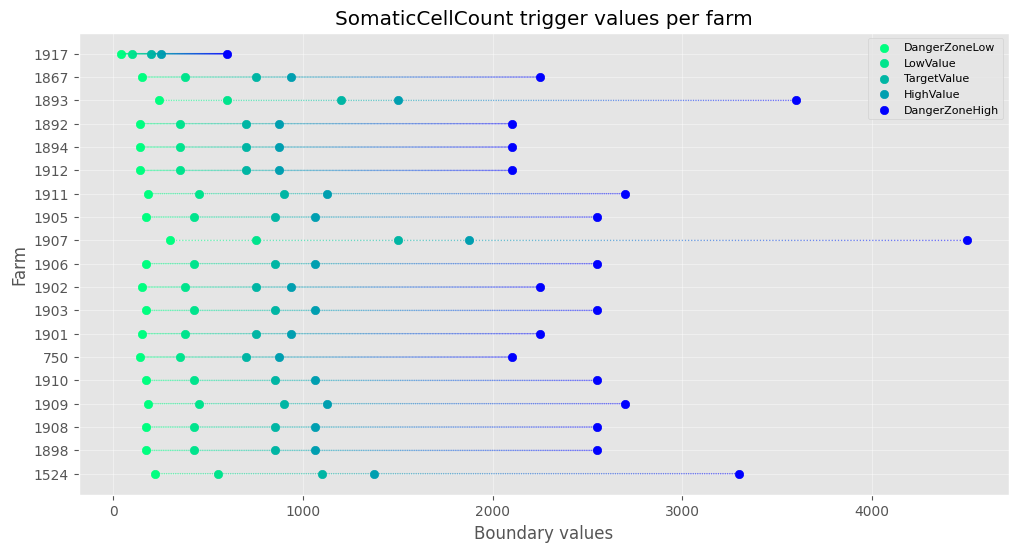

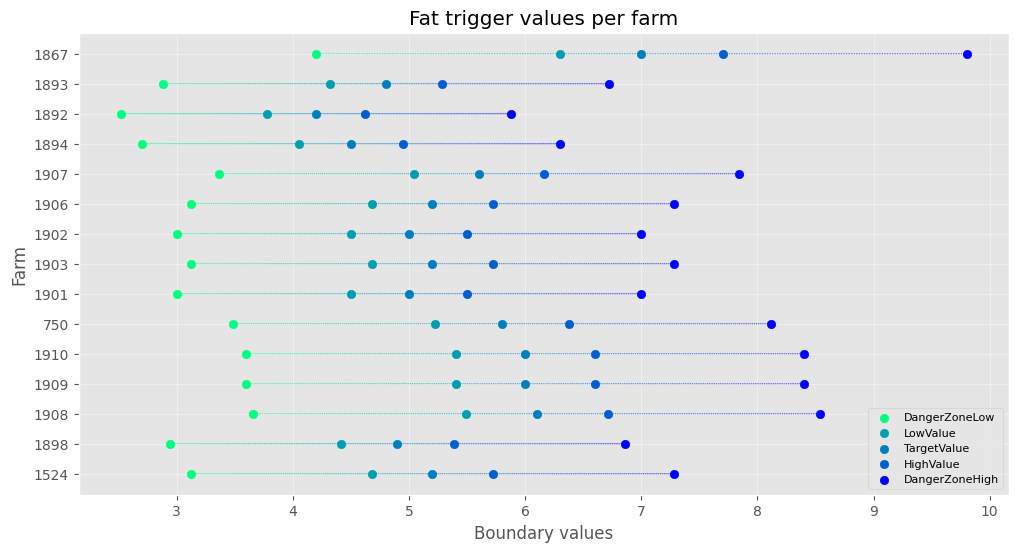

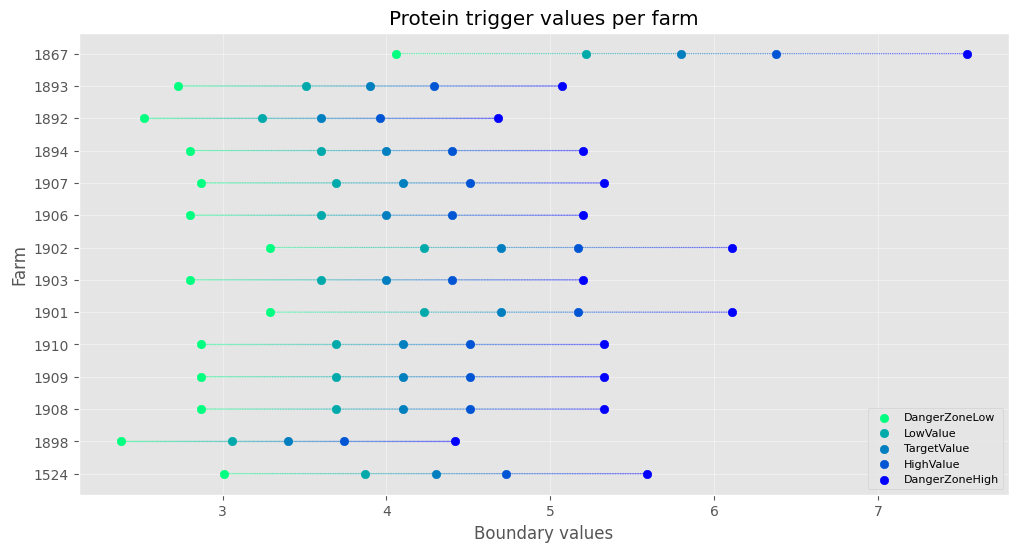

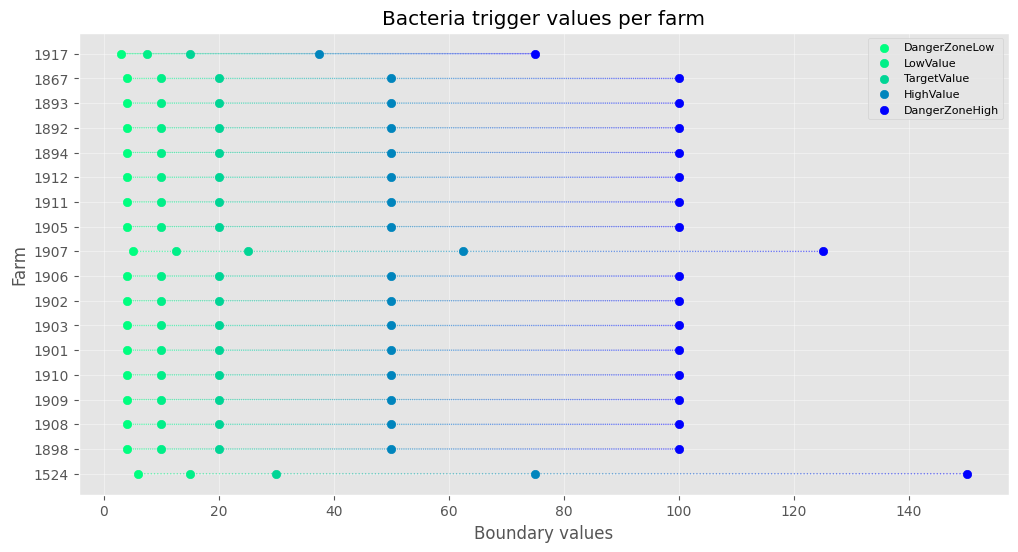

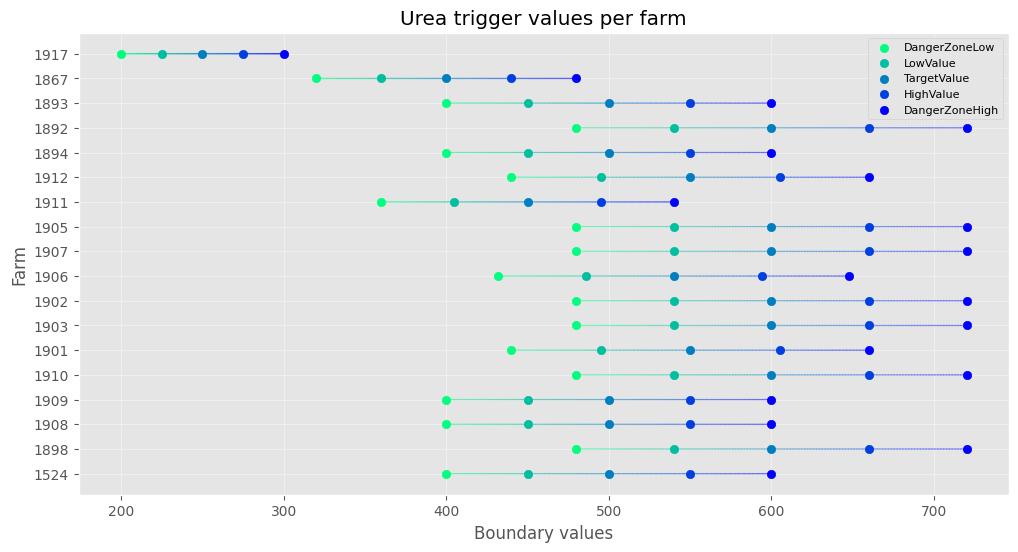

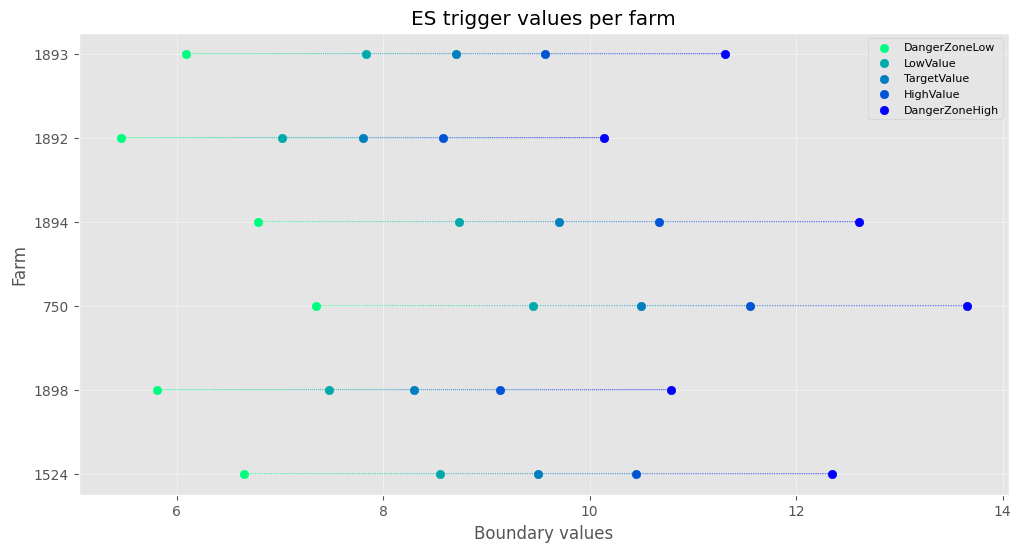

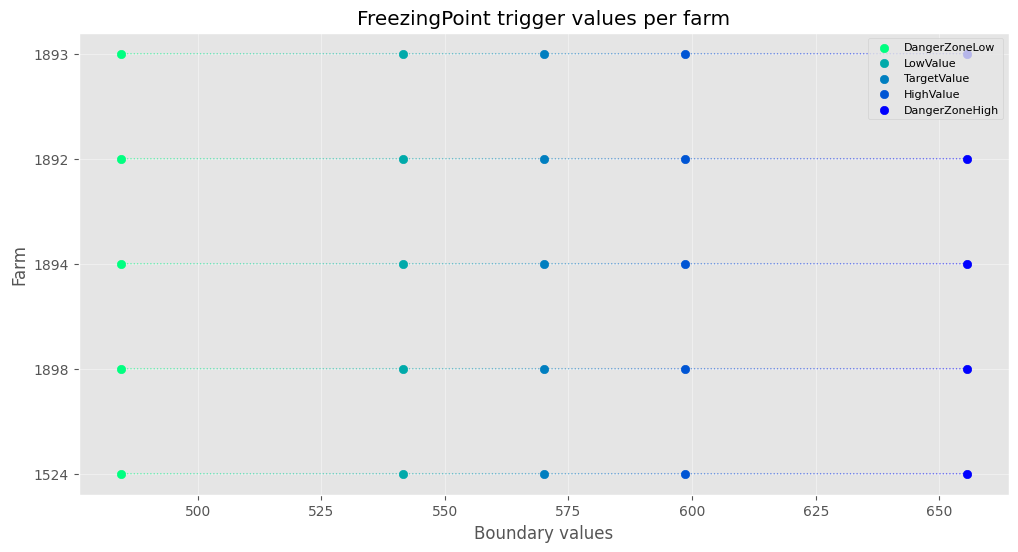

In [13]:
# Measurement ranges for known farms only
MeasurementRange = (
    MilkMeasurements[["ManagementAreaId"]]
    .drop_duplicates()
    .merge(MeasurementRange, on="ManagementAreaId")
)

# Columns containing the intervals bounding for each farm
boundary_columns = [
    "DangerZoneLow",
    "LowValue",
    "TargetValue",
    "HighValue",
    "DangerZoneHigh",
]

# Plot colormap
cmap = plt.get_cmap("winter_r")

# Save folder
images_subfolder = Path("2 - Measurement trigger values per farm")

# Iterate over each milk characteristic
for _, (MeasurementTypeId, Measurement) in MeasurementType.iterrows():
    fig, ax = plt.subplots(figsize=(12, 6))

    # Data for a specific milk measurement
    MeasurementRangeData = MeasurementRange[
        MeasurementRange["MeasurementTypeId"] == MeasurementTypeId
    ][["ManagementAreaId"] + boundary_columns]

    # Iterate over each farm
    for i, (_, row) in enumerate(MeasurementRangeData.iterrows()):
        # Get the farm
        ManagementAreaId = row["ManagementAreaId"]

        # Get the boundary values
        boundary_values = row[boundary_columns].values

        # Normalize the values to range [0, 1] for colormap
        norm_values = (boundary_values - boundary_values.min()) / (
            boundary_values.max() - boundary_values.min()
        )

        # Get the colors for each point
        point_colors = [cmap(norm) for norm in norm_values]

        # Iterate over each boundary value
        for j, value in enumerate(boundary_values):
            if i == 0:  # add legend once
                ax.scatter(
                    value,
                    ManagementAreaId,
                    color=point_colors[j],
                    label=boundary_columns[j],
                )
            else:
                ax.scatter(value, ManagementAreaId, color=point_colors[j])

        # Plot a line connecting the points with gradient colors
        line_x = np.linspace(boundary_values[0], boundary_values[-1], 256)
        line_y = [ManagementAreaId] * 256
        line_colors = [cmap(i) for i in range(256)]
        ax.scatter(line_x, line_y, color=line_colors, s=0.4, alpha=0.4)

    # Labels, title, grid and legend
    ax.set_xlabel("Boundary values")
    ax.set_ylabel("Farm")
    title = f"{Measurement} trigger values per farm"
    ax.set_title(title)
    ax.grid(True, alpha=0.4)
    ax.legend(fontsize=8)

    # Save and display the plot
    plt.savefig(images / images_subfolder / f"{title}.png")
    plt.show()

# Distribution of trigger values per farm

In [14]:
# Load saved (melted) data
MeltedMilkMeasurements = pd.read_csv(output / "MeltedMilkMeasurements.csv")
MeltedMilkMeasurements.head()

,Id,ManagementAreaId,MeasurementTypeId,Measurement,Value,Rank,TriggerValue
0,1401,750,3,SomaticCellCount,1273.00,9,High
1,1401,750,4,Fat,4.47,7,Low
2,1401,750,8,ES,8.28,8,Low
3,1402,750,3,SomaticCellCount,1288.00,9,High
4,1402,750,4,Fat,4.66,7,Low


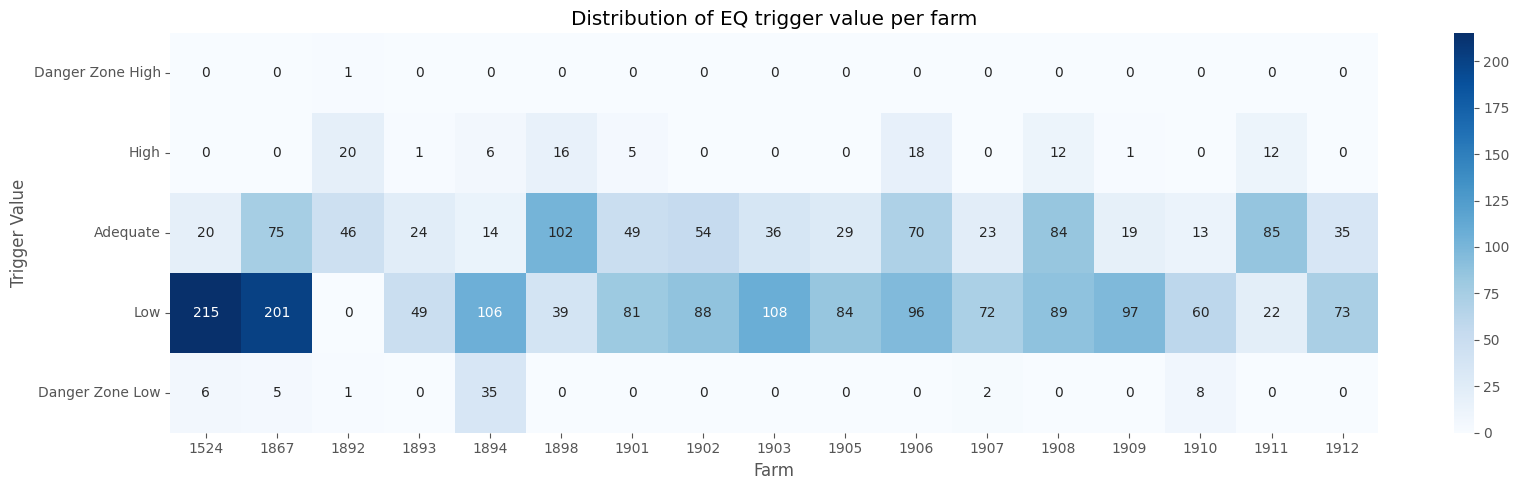

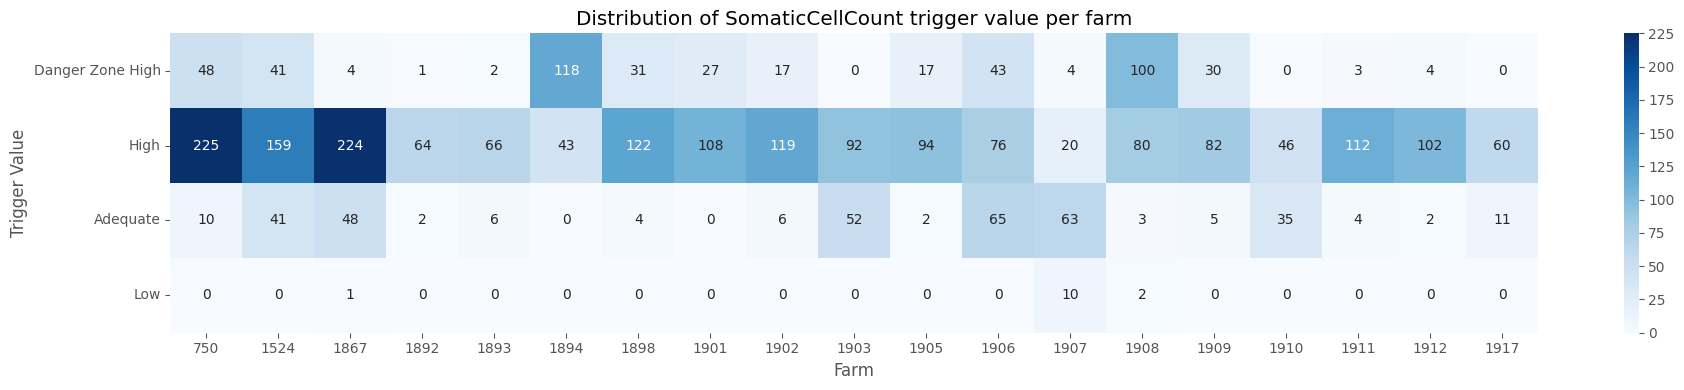

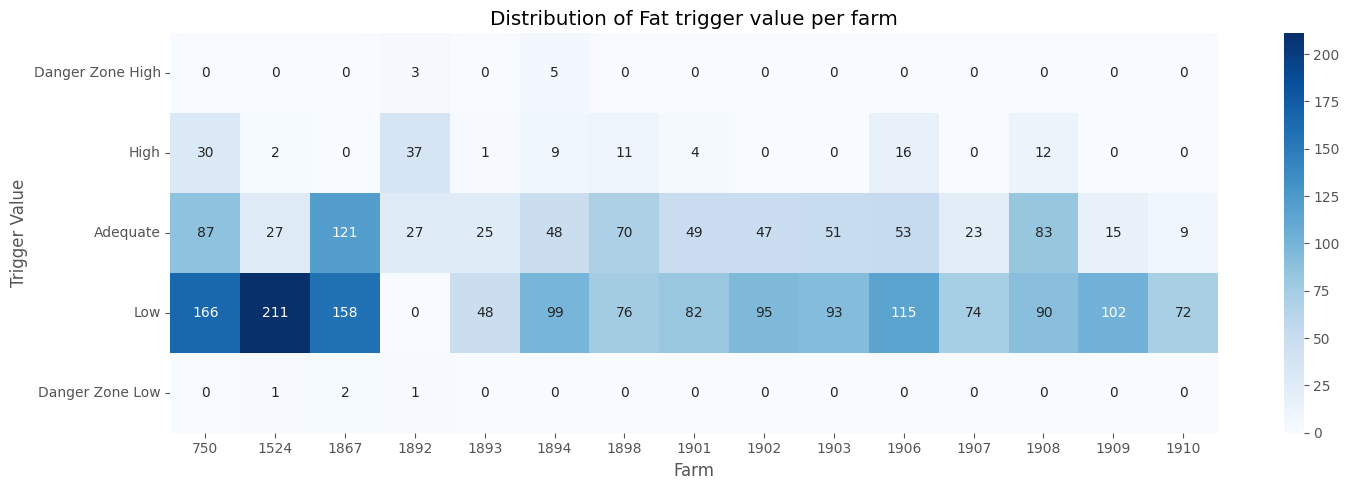

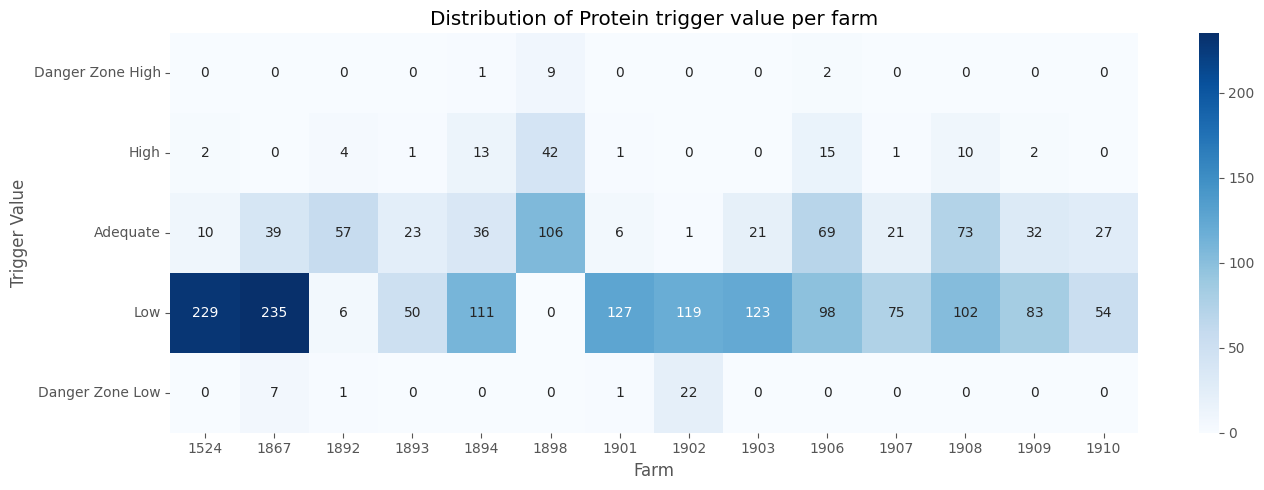

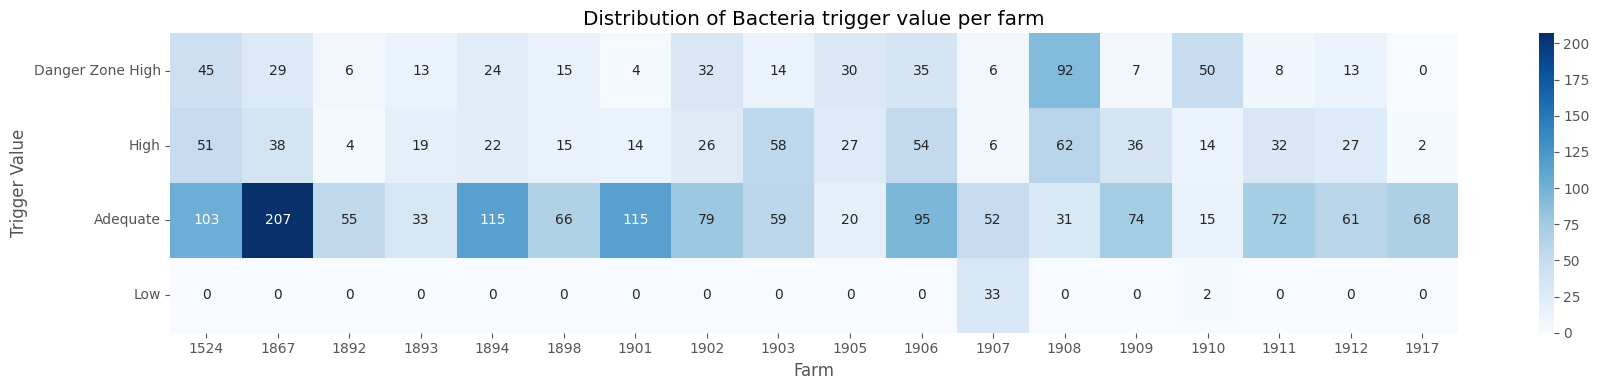

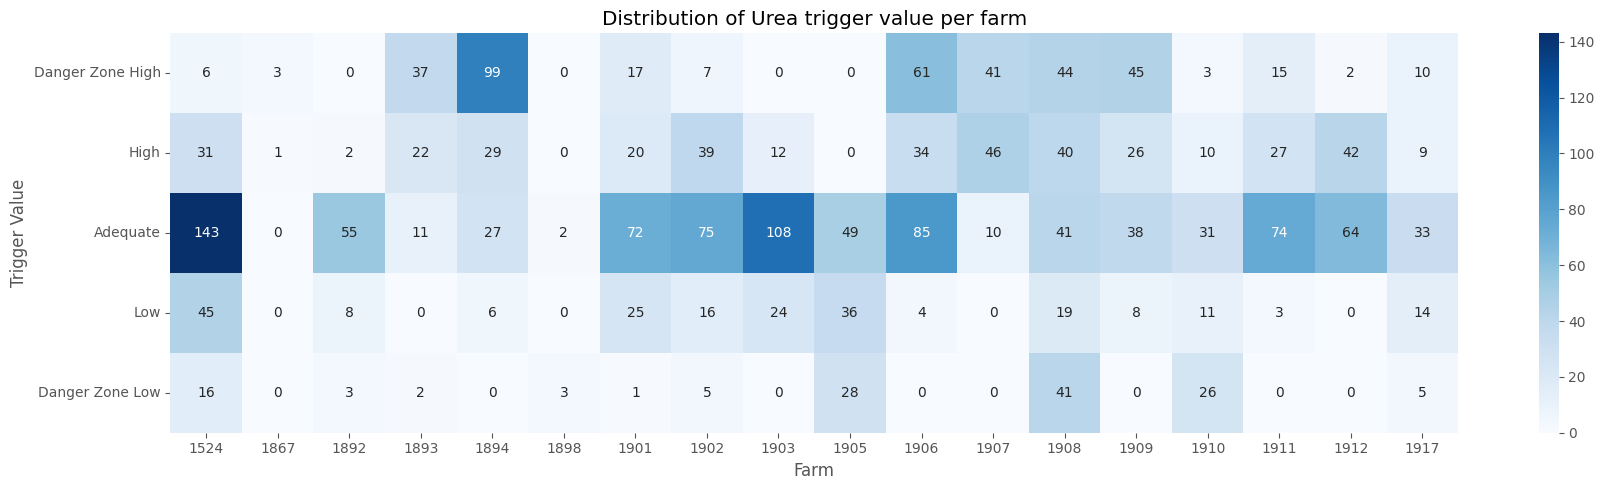

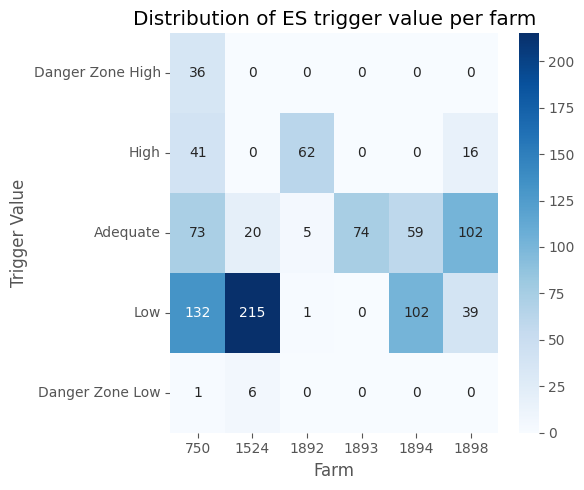

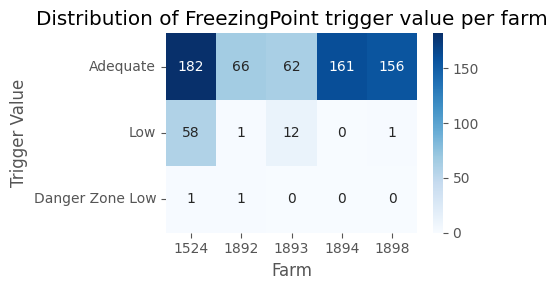

In [15]:
# Dictionary to correctly sort the data
boundaries_order = {
    value: index
    for index, value in enumerate(
        ["Danger Zone High", "High", "Adequate", "Low", "Danger Zone Low"]
    )
}

# Save folder
images_subfolder = Path("3 - Distribution of trigger values per farm")

# Iterate over each milk characteristic
for _, (_, Measurement) in MeasurementType.iterrows():
    # Count data points per farm and trigger value
    MeasurementDistributionPerFarm = (
        MeltedMilkMeasurements[MeltedMilkMeasurements["Measurement"] == Measurement]
        .groupby(["ManagementAreaId", "TriggerValue"])
        .size()
        .reset_index(name="Count")
        .pivot(index="TriggerValue", columns="ManagementAreaId", values="Count")
        .fillna(0)
    )

    # Order the resulting data
    new_index_order = sorted(
        MeasurementDistributionPerFarm.index,
        key=lambda item: boundaries_order.get(item),
    )
    MeasurementDistributionPerFarm = MeasurementDistributionPerFarm.reindex(
        new_index_order
    )

    # Plot the count matrix
    plt.figure(figsize=MeasurementDistributionPerFarm.shape[::-1])
    sns.heatmap(MeasurementDistributionPerFarm, annot=True, fmt="g", cmap="Blues")

    # Title, ticks, labels, save and display
    title = f"Distribution of {Measurement} trigger value per farm"
    plt.title(title)
    plt.xlabel("Farm")
    plt.xticks(rotation=0)
    plt.ylabel("Trigger Value")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(images / images_subfolder / f"{title}.png")
    plt.show()